In [120]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [121]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               705 non-null    object 
 1   Player             705 non-null    object 
 2   MatchId            705 non-null    object 
 3   Map                705 non-null    object 
 4   Category           705 non-null    object 
 5   Playlist           705 non-null    object 
 6   Input              705 non-null    object 
 7   Queue              705 non-null    object 
 8   PreCsr             705 non-null    int64  
 9   PostCsr            705 non-null    int64  
 10  Rank               705 non-null    int64  
 11  WasAtStart         705 non-null    int64  
 12  WasAtEnd           705 non-null    int64  
 13  WasInProgressJoin  705 non-null    int64  
 14  Mmr                2 non-null      float64
 15  Outcome            705 non-null    object 
 16  Accuracy           705 non

In [122]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
# Per 10 Min
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
# Excess
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['ExcessKD'] = df['KD'] - (df['ExpectedKills'] / df['ExpectedDeaths'])
# Kill Type
df['BodyPct'] = df['KillsBody'] / df['Kills'] *100
df['MeleePct'] = df['KillsMelee'] / df['Kills'] * 100
df['HSPct'] = df['KillsHeadshot'] / df['Kills'] * 100
df['GrenadePct'] = df['KillsGrenade'] / df['Kills'] * 100
df['PowerPct'] = df['KillsPower'] / df['Kills'] * 100



df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'PreCsr', 'PostCsr', 'ShotsFired', 'AssistsEmp',
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides', 'WasAtStart', 'WasAtEnd', 'AssistsDriver',
              'Perfects', 'WasInProgressJoin', 'VehicleDestroys', 'VehicleHijacks', 'AssistsCallout',
              'LengthSeconds', 'Rank'],axis=1)
df = df.drop(['KillsMelee', 'KillsGrenade', 'KillsHeadshot', 'KillsPower'], axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 140 to 704
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Map             463 non-null    object 
 1   Outcome         463 non-null    int64  
 2   Accuracy        463 non-null    float64
 3   DamageDone      463 non-null    int64  
 4   DamageTaken     463 non-null    int64  
 5   KD              463 non-null    float64
 6   KDA             463 non-null    float64
 7   Kills           463 non-null    int64  
 8   Deaths          463 non-null    int64  
 9   Assists         463 non-null    int64  
 10  MaxSpree        463 non-null    int64  
 11  ExpectedKills   463 non-null    float64
 12  ExpectedDeaths  463 non-null    float64
 13  Score           463 non-null    int64  
 14  Medals          463 non-null    int64  
 15  LengthMinutes   463 non-null    float64
 16  KillsBody       463 non-null    int64  
 17  DamageRatio     463 non-null    f

In [123]:
def cnt(df, col):
    count = df[col].count()
    return count
def sm(df, col):
    sum = df[col].sum()
    return sum
def avg(df, col, val=None):
    avg = round(sm(df, col) / cnt(df, col),val)
    return avg


In [124]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.451970
DmgT/10Min        0.370210
KD                0.333050
Deaths            0.329310
ExcessDeaths      0.284183
DamageRatio       0.281095
KDA               0.273576
DamageTaken       0.249840
ExcessKD          0.242424
ExpectedDeaths    0.205342
Damage/Kill       0.176246
Assists/10Min     0.169981
LengthMinutes     0.130765
Kills/10Min       0.124264
MaxSpree          0.121108
DamageDone        0.097335
Accuracy          0.059293
Assists           0.040100
Shots/10Min       0.031604
Score             0.029583
Kills             0.028149
ExpectedKills     0.026331
MeleePct          0.024786
BodyPct           0.018690
Dmg/10Min         0.018034
Medals            0.016625
ExcessKills       0.015945
PowerPct          0.010398
KillsBody         0.006473
HSPct             0.006336
GrenadePct        0.002207
Name: Outcome, dtype: float64


In [125]:
# dfRR.hist(bins=15, figsize=(16, 12))
# plt.tight_layout()
# plt.show()

In [126]:
dfRR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Outcome,463.0,0.537797,0.499109,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,463.0,51.528898,5.172080,36.800000,48.390000,51.500000,54.660000,80.560000
DamageDone,463.0,5189.328294,1799.144484,667.000000,3866.000000,4931.000000,6316.500000,12673.000000
DamageTaken,463.0,4444.187905,1502.650948,875.000000,3448.500000,4220.000000,5346.500000,9962.000000
KD,463.0,1.257862,0.669975,0.270000,0.860000,1.130000,1.445000,6.000000
KDA,463.0,4.565335,5.620197,-9.660000,0.660000,4.660000,7.830000,31.000000
Kills,463.0,14.654428,6.309257,1.000000,10.000000,14.000000,18.000000,40.000000
Deaths,463.0,12.898488,5.040148,1.000000,9.000000,13.000000,16.000000,30.000000
Assists,463.0,8.434125,4.207224,1.000000,6.000000,8.000000,11.000000,28.000000
MaxSpree,463.0,3.924406,1.533433,1.000000,3.000000,4.000000,5.000000,10.000000


In [127]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [128]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
X = round(X,20)
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (463, 32)
Y Shape: (463,)


In [129]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=2)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')

X Train Shape: (370, 32)
X Test Shape: (93, 32)


In [130]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['KD', 'KDA', 'Kills', 'Deaths', 'Assists', 'DamageDone', 'DamageTaken', 'DamageRatio', 
                                   'Damage/Kill', 'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min', 'DmgT/10Min',
                                   'ExcessKills', 'ExcessDeaths', 'ExcessKD', 'ExpectedKills', 'ExpectedDeaths', 'Score', 'Shots/10Min']),
        ('cat', OneHotEncoder(), ['Map'])
    ])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

In [131]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MSE_Histmean = mean_squared_error(y_test,np.full(y_test.shape,np.mean(y_train)))

def ResultsOut(model):
  y_pred = model.predict(X_test_preprocessed)
  # Calculate regression metrics
  acc = model.score(X_test_preprocessed, y_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)
  oosr2 = 1-mean_squared_error(y_test,y_pred)/MSE_Histmean
  # Print the metrics with newline characters
  print("Acc: {:.3f}".format(acc))
  print("MAE: {:.2f}".format(mae))
  print("MSE: {:.2f}".format(mse))
  print("RMSE: {:.2f}".format(rmse))
  print("R^2 Score: {:.2f}".format(r2))
  print("OOS R^2 Score: {:.2f}".format(oosr2))
  return ''

def paramResults(mod):
    results_df = pd.DataFrame({'param': mod.cv_results_["params"], 'Accuracy': mod.cv_results_["mean_test_score"]})

    # Splitting the 'param' column into separate columns
    params_df = pd.DataFrame(results_df['param'].to_list())
    params_df.columns = [f"{col}_param" for col in params_df.columns]

    # Concatenating the new columns with the 'Accuracy' column
    results_df = pd.concat([params_df, results_df['Accuracy']], axis=1)

    # Displaying the updated DataFrame
    print(results_df)
    return ''

def featImport(mod):
    feat_importances = pd.DataFrame(mod.best_estimator_.feature_importances_[:20], index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))
    plt.show()

## Logistic Regression

In [132]:
# Unregularized Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(penalty=None)
logreg.fit(X_train_preprocessed, y_train)

print(f'Unregularized Logistic Regression Accuracy: {logreg.score(X_test_preprocessed, y_test)}')
print(ResultsOut(logreg))

Unregularized Logistic Regression Accuracy: 0.7956989247311828
Acc: 0.796
MAE: 0.20
MSE: 0.20
RMSE: 0.45
R^2 Score: 0.17
OOS R^2 Score: 0.17



## Ridge

In [133]:
# Ridge
# Need to find best params for param grid

C_grid = [10**-3,10**-2,10**-1,10**0,10**1,10**2]

param_grid={'C':C_grid}
ridge_cv = GridSearchCV(LogisticRegression(penalty='l2',solver='saga'),
                                          param_grid=param_grid,cv=5)
ridge_cv.fit(X_train_preprocessed,y_train)

print(ridge_cv.best_estimator_)
print(f'Ridge Accuracy: {ridge_cv.score(X_test_preprocessed, y_test)}')
ridge_cv.cv_results_
paramResults(ridge_cv)

LogisticRegression(C=10, solver='saga')
Ridge Accuracy: 0.7956989247311828
   C_param  Accuracy
0    0.001  0.686486
1    0.010  0.721622
2    0.100  0.783784
3    1.000  0.797297
4   10.000  0.800000
5  100.000  0.794595


''

In [134]:
ResultsOut(ridge_cv)

Acc: 0.796
MAE: 0.20
MSE: 0.20
RMSE: 0.45
R^2 Score: 0.17
OOS R^2 Score: 0.17


''

## Lasso

In [135]:
# Lasso

param_grid={'C':C_grid}
lasso_cv = GridSearchCV(LogisticRegression(penalty='l1',solver='saga'),
                                          param_grid=param_grid,cv=5)
lasso_cv.fit(X_train_preprocessed,y_train)

print(lasso_cv.best_estimator_)
print(f'Lasso Accuracy: {lasso_cv.score(X_test_preprocessed, y_test)}')
lasso_cv.cv_results_
paramResults(lasso_cv)


LogisticRegression(C=1, penalty='l1', solver='saga')
Lasso Accuracy: 0.7634408602150538
   C_param  Accuracy
0    0.001  0.502703
1    0.010  0.529730
2    0.100  0.729730
3    1.000  0.802703
4   10.000  0.797297
5  100.000  0.794595


''

In [136]:
ResultsOut(lasso_cv)

Acc: 0.763
MAE: 0.24
MSE: 0.24
RMSE: 0.49
R^2 Score: 0.03
OOS R^2 Score: 0.04


''

## ElasticNet

In [137]:
# ElasticNet

param_grid2={'C':C_grid,'l1_ratio':[.25, .5, .75]}

elastic_cv = GridSearchCV(LogisticRegression(penalty='elasticnet',solver='saga'),
                                            param_grid=param_grid2,cv=5)
elastic_cv.fit(X_train_preprocessed,y_train)

print(elastic_cv.best_estimator_)
print(f'ElasticNet Accuracy: {elastic_cv.score(X_test_preprocessed, y_test)}')
elastic_cv.cv_results_
paramResults(elastic_cv)

LogisticRegression(C=1, l1_ratio=0.5, penalty='elasticnet', solver='saga')
ElasticNet Accuracy: 0.7634408602150538
    C_param  l1_ratio_param  Accuracy
0     0.001            0.25  0.529730
1     0.001            0.50  0.529730
2     0.001            0.75  0.518919
3     0.010            0.25  0.708108
4     0.010            0.50  0.637838
5     0.010            0.75  0.529730
6     0.100            0.25  0.770270
7     0.100            0.50  0.762162
8     0.100            0.75  0.745946
9     1.000            0.25  0.797297
10    1.000            0.50  0.802703
11    1.000            0.75  0.802703
12   10.000            0.25  0.797297
13   10.000            0.50  0.800000
14   10.000            0.75  0.797297
15  100.000            0.25  0.797297
16  100.000            0.50  0.794595
17  100.000            0.75  0.797297


''

In [138]:
ResultsOut(elastic_cv)

Acc: 0.763
MAE: 0.24
MSE: 0.24
RMSE: 0.49
R^2 Score: 0.03
OOS R^2 Score: 0.04


''

## K-Nearest Neighbours

In [139]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

k_values = list(range(1,50,3))
param_grid = {'n_neighbors': k_values}

knn_cv = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knn_cv.fit(X_train_preprocessed,y_train)

print(knn_cv.best_estimator_)
print(f'K-Nearest Neighbors Accuracy: {knn_cv.score(X_test_preprocessed, y_test)}')
knn_cv.cv_results_
paramResults(knn_cv)

KNeighborsClassifier(n_neighbors=49)
K-Nearest Neighbors Accuracy: 0.7204301075268817
    n_neighbors_param  Accuracy
0                   1  0.624324
1                   4  0.675676
2                   7  0.681081
3                  10  0.675676
4                  13  0.664865
5                  16  0.683784
6                  19  0.683784
7                  22  0.694595
8                  25  0.672973
9                  28  0.681081
10                 31  0.694595
11                 34  0.697297
12                 37  0.689189
13                 40  0.694595
14                 43  0.689189
15                 46  0.697297
16                 49  0.705405


''

In [140]:
ResultsOut(knn_cv)

Acc: 0.720
MAE: 0.28
MSE: 0.28
RMSE: 0.53
R^2 Score: -0.14
OOS R^2 Score: -0.13


''

## Random Forest

In [141]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'n_estimators': [100,300,500],'max_depth': [10, 15, 20]}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=69,max_features='sqrt'),
                                                     cv=5, param_grid=param_grid_rf,n_jobs=-1)
rf_cv.fit(X_train_preprocessed, y_train)

print(rf_cv.best_estimator_)
print(f'Random Forest Accuracy: {rf_cv.score(X_test_preprocessed, y_test)}')
rf_cv.cv_results_
paramResults(rf_cv)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=69)
Random Forest Accuracy: 0.7419354838709677
   max_depth_param  n_estimators_param  Accuracy
0               10                 100  0.702703
1               10                 300  0.718919
2               10                 500  0.713514
3               15                 100  0.708108
4               15                 300  0.702703
5               15                 500  0.697297
6               20                 100  0.708108
7               20                 300  0.705405
8               20                 500  0.700000


''

In [142]:
ResultsOut(rf_cv)

Acc: 0.742
MAE: 0.26
MSE: 0.26
RMSE: 0.51
R^2 Score: -0.05
OOS R^2 Score: -0.05


''

<AxesSubplot: >

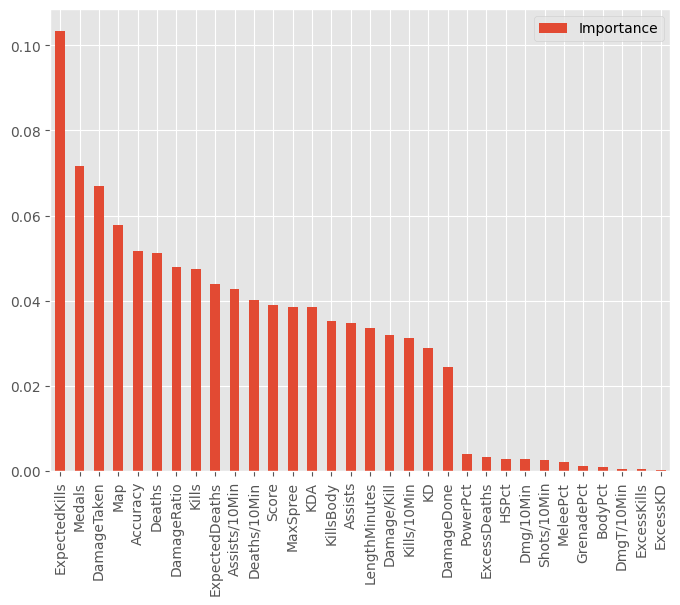

In [143]:
feat_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_[:32], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Gradient Boosted Trees

In [144]:
# Gradient Boosted Trees
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbrt = {'n_estimators': [100,300,500],'learning_rate': [0.01,0.1],'max_depth': [2,4,6], 'subsample': [0.5,1]}
GBRT = GridSearchCV(estimator=GradientBoostingClassifier(random_state=69),
                    cv=5, param_grid=param_grid_gbrt,n_jobs=-1)
GBRT.fit(X_train_preprocessed, y_train)

print(GBRT.best_estimator_)
print(f'Gradient Boosed Trees Accuracy: {GBRT.score(X_test_preprocessed, y_test)}')
GBRT.cv_results_
paramResults(GBRT)

GradientBoostingClassifier(max_depth=2, n_estimators=300, random_state=69,
                           subsample=0.5)
Gradient Boosed Trees Accuracy: 0.7096774193548387
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                2                 100              0.5   
1                  0.01                2                 100              1.0   
2                  0.01                2                 300              0.5   
3                  0.01                2                 300              1.0   
4                  0.01                2                 500              0.5   
5                  0.01                2                 500              1.0   
6                  0.01                4                 100              0.5   
7                  0.01                4                 100              1.0   
8                  0.01                4                 300              0.5   
9                  0.0

''

In [145]:
ResultsOut(GBRT)

Acc: 0.710
MAE: 0.29
MSE: 0.29
RMSE: 0.54
R^2 Score: -0.18
OOS R^2 Score: -0.18


''

<AxesSubplot: >

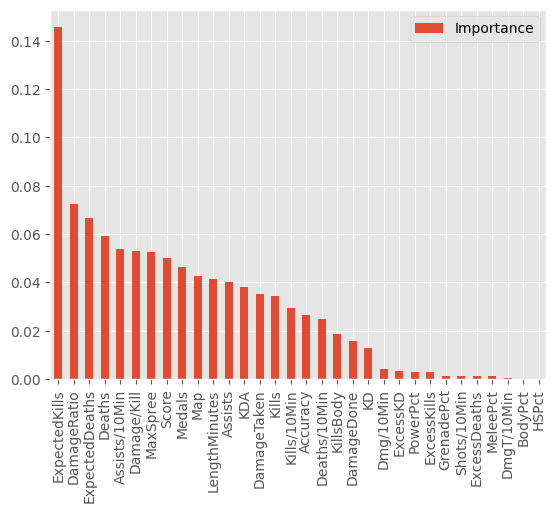

In [147]:
feat_importances = pd.DataFrame(GBRT.best_estimator_.feature_importances_[:32], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

## XGBoost

In [148]:
from xgboost import XGBClassifier

param_grid_xgb = {'n_estimators': [400,450,475,500],'learning_rate': [0.001,0.01,0.1,0.25],'max_depth': [1,2,3,4,5]}
XGB = GridSearchCV(estimator=XGBClassifier(random_state=69), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
XGB.fit(X_train_preprocessed, y_train)

print(XGB.best_estimator_)
print(f'XGBoost Accuracy: {XGB.score(X_test_preprocessed, y_test)}')
paramResults(XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...)
XGBoost Accuracy: 0.7096774193548387
    learning_rate_param  max_depth_param  n_estimators_param  Accuracy
0                 0.001                1                 400  0.729730
1                 0.001                1                 450  0.729730
2   

''

In [149]:
ResultsOut(XGB)

Acc: 0.710
MAE: 0.29
MSE: 0.29
RMSE: 0.54
R^2 Score: -0.18
OOS R^2 Score: -0.18


''

<AxesSubplot: >

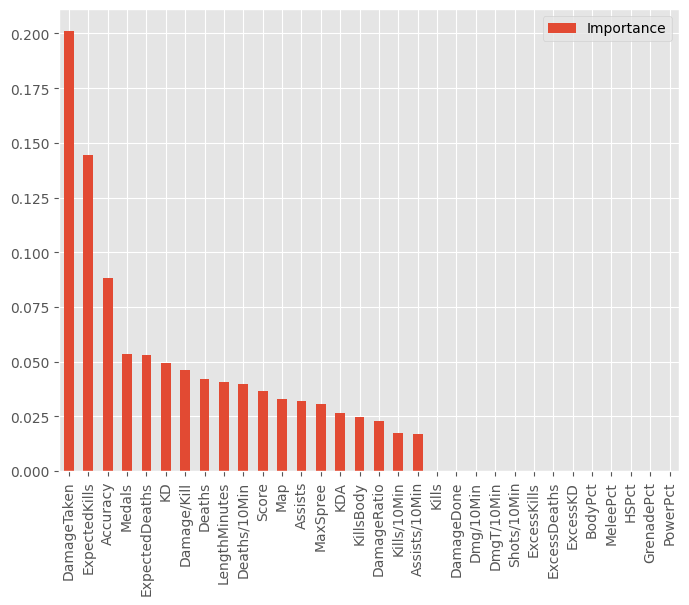

In [151]:
feat_importances = pd.DataFrame(XGB.best_estimator_.feature_importances_[:32], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

Runtime: 101.29s


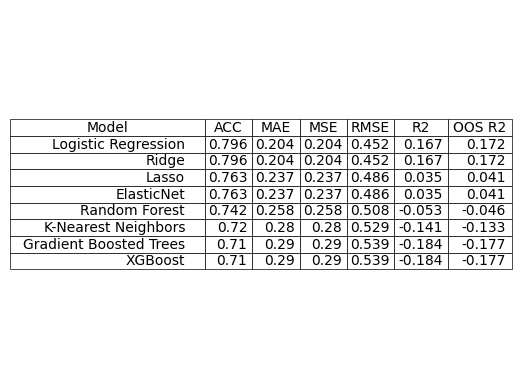

In [152]:
modelss = [logreg,ridge_cv,lasso_cv,elastic_cv,knn_cv,rf_cv,GBRT,XGB]
model_namess = ['Logistic Regression', 'Ridge', 'Lasso', 'ElasticNet',
              'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted Trees', 'XGBoost']
def saveResults(models, model_names):
    # Initialize an empty dataframe to store the metrics
    metrics_df = pd.DataFrame(columns=['Model', 'ACC' ,'MAE', 'MSE', 'RMSE', 'R2', 'OOS R2'])
    
    # Loop through each model and calculate the metrics
    for i, model in enumerate(models):
        # Generate predictions on the test set
        y_pred = model.predict(X_test_preprocessed)
        
        # Calculate regression metrics
        acc = round(model.score(X_test_preprocessed, y_test),3)
        mae = round(mean_absolute_error(y_test, y_pred),3)
        mse = round(mean_squared_error(y_test, y_pred),3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),3)
        r2 = round(r2_score(y_test, y_pred),3)
        oosr2 = round(1-mean_squared_error(y_test,y_pred)/MSE_Histmean,3)
        
        # Add metrics to the dataframe
        metrics_df.loc[i] = [model_names[i],acc, mae, mse, rmse, r2, oosr2]
    
    metrics_df = metrics_df.sort_values('ACC', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots()
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                     cellLoc='right', loc='center')
    table.auto_set_font_size(True)
    table.auto_set_column_width(col=list(range(len(metrics_df.columns))))
    ax.axis('off')
    plt.savefig('ModelResults0210.png', dpi=300, bbox_inches='tight')
    
    return metrics_df

saveResults(modelss,model_namess)
print(f'Runtime: {round(time.perf_counter() - start,2)}s')